<center>
    <h3>University of Toronto</h3>
    <h3>Department of Mechanical and Industrial Engineering</h3>
    <h3>MIE368 Analytics in Action </h3>
    <h3>(Fall 2020)</h3>
    <hr>
    <h1>Lab 6: Simulation</h1>
    <h3>November 4, 2020</h3>
</center>




# Introduction

Simulation is a widely used approach to model a process or system over some time period. In particular, simulation can be used to understand how a system performs and/or responds to changes in parameters. Although simulation models can be coded from scratch using Python or another language, many different commercial software packages exist to simplify the process for the user (e.g., SIMUL8, AnyLogic). Simulation is widely used in practice across multiple fields such as healthcare, manufacturing, telecommunications, transportation, disaster preparedness, etc. 

One of the main advantages of simulation is the ability to model the behaviour of complex systems that are otherwise difficult to understand. In this way, simulation can be used to obtain empirical estimations for how a system performs. However, the cost of simulation is that it can be computationally expensive depending on the complexity of the underlying system and the number of repetitions required. 



## Types of simulation

Typically, we use simulation to understand how various parameters impact the overall system performance. For example, suppose we want to understand the effect of parameter $p$ on the overall system performance. Note that $p$ might be a user-chosen parameter (i.e., something that we can control like the number of nurses on duty) or it may be a system parameter that is out of our control (i.e., arrival rate of patients). In either case, we may have some prior knowledge about $p$ and it's underlying distribution. We describe some of the most common approaches for using this information as part of a simulation model:

- **Deterministic:** The user chooses a value for $p$ corresponding to their "best guess". We then simulate and record the system performance. This approach is useful for understanding how the system performs for a given fixed input value $p$, but is not useful for understanding how the system responds to changes in $p$.
- **What-if scenarios:** The user chooses various values for $p$ corresponding to different scenarios, such as optimistic, pessimistic, typical, etc. The number of scenarios can range from $2$ to over $1,000,000$. For each scenario, we simulate and record the system performance. In this way, we can develop an understanding of how the system responds to changes in $p$ by estimating the empirical performance for discrete values of $p$. 
- **Monte Carlo:** The user defines a probability distribution for $p$. We repeatedly sample values of $p$ from this distribution and for each sample, we simulate and record the system performance. We can use these results to obtain empirical probability distributions for the system performance as a function of $p$. 

Effectively, the key difference between the three can be summarized as follows. A deterministic simulation is a single simulation of a non-random event. A what-if simulation is a sweep over different settings of the deterministic simulation. A Monte Carlo simulation is an estimate of the probability of outcomes when the parameter is not known in advance, but has some random component.


## Law of large numbers

The guiding principle behind Monte Carlo simulations is the Law of Large Numbers, which states that if you repeat an experiment and record the outcome enough times, then the average over the experimental results will eventually converge to the true expected outcome of the experiment. In a Monte Carlo simulation, we assume that we have access to a probability distribution on a simulation parameter. Thus, if we repeatedly sample from the distribution, complete the experiment, and record the outcome, then the empirical frequencies of the experiment outcomes will eventually converge to the true distribution of the model.

There are two key weaknesses in Monte Carlo simulations. The first is our assumption that we have a probability distribution on the parameter. In practice, we often don't have this distribution, but only have an estimate or approximation of the distribution. Thus, if our approximation is not accurate, then the Monte Carlo simulations will also be inaccurate. Secondly, designing and running an accurate simulation of an experiment is often computationally expensive. When you couple that with the fact that you often need to run the experiment a large number of times in order to get your empirical distributions to converge, it may simply take too long or too much computational resources to design an accurate Monte Carlo simulation.




# Application

Chess is a board game between two players 'white' and 'black'. Chess players are given a rating, known as the ELO rating (or score), that is meant to determine how good of a player they are. When a player starts playing, they begin with a default ELO score of 1500. This score then increases or decreases as the player wins or loses games. For example, if two players with scores of 1500 play each other, the winner's score will increase to 1518 and the loser's will drop to 1482. The amount of increase or decrease is determined by the initial difference between the two players scores. In general, if you play someone with a higher ELO than you and you win, then your score will increase and theirs will decrease by a large number. However, if they win, then the change in scores will be small.


In competitive chess, games are scored by getting 1 point for winning and a 0.5 point for drawing. In this lab, we will simulate several different chess tournaments, where a group of players will play with each other over several rounds. We have provided a dataset of players and their ELOs. From this, we will build a model to predict the likelihood of winning between two players, and decide matches by sampling from this distribution. We will run a Monte Carlo simulation over a given tournament in order to determine every player's likelihood of winning.

In this lab, we will simulate two simple tournament stypes:

- $n$-Round robin: each player plays every other player $n$ times. After all of the matches are played, the player with the most points wins the tournament.
- $n$-Elimination: Players are assigned a random seed into a knock-out tournament. In every round, the winner is decided by a best of $n$ games. 

Our objective will be to design a "fair" tournament that requires the fewest number of games. While determining what fairness means is already a tough problem, for the purposes of the lab, let us say that a fair tournament is one where the best player has at least a 90% chance of winning.





First, let us import the essential tools.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Exploring the data
Load the dataset and store it in a variable ```df```.

In [ ]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1D0ENZQSf7GQ0JmqFgAIkRA_xQb7SpB3n')
df.head()

,white_id,white_rating,black_id,black_rating,winner
0,bourgris,1500,a-00,1191,white
1,a-00,1322,skinnerua,1261,black
2,ischia,1496,a-00,1500,white
3,daniamurashov,1439,adivanov2009,1454,white
4,nik221107,1523,adivanov2009,1469,white


The table below contains the data dictionary.

|Feature          |Definition                       |
|:---------------:|:--------------------------------|
|white_id         |Player id of the white player    |
|black_id         |Player id of the black player    |    
|white_rating     |ELO score of the white player    |
|black_rating     |ELO score of the black player    |
|winner           |'white', 'black', or 'draw'      |

ELO scores were initially designed in the 20th century as a measure of player quality. Generally, the average player has a rating between 1500-1600. Magnus Carlsen, the current Chess world champion, has an official rating of 2845!
Let's take a look at the quality of players in our dataset. 

The following code creates a new Series to store player ids and their ratings. It also plots a histogram of the ELO scores in the dataset with the number of bins set to 30.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2df2c66358>]],
      dtype=object)

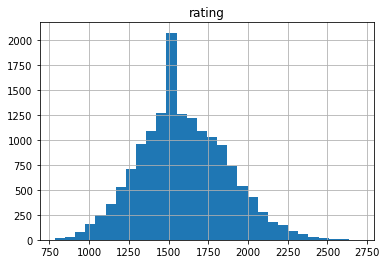

In [ ]:
# The code below creates a dataframe of players
white_players = df[['white_id', 'white_rating']]
white_players.columns = ['id', 'rating']
black_players = df[['black_id', 'black_rating']]
black_players.columns = ['id', 'rating']
players = pd.concat([white_players, black_players])
# Drop duplicates (coming from players playing multiple games) and set
# the index to be their ids
players = players.drop_duplicates(subset='id')
players = players.set_index('id')
players.hist(bins=30)

### Exercise

The ELO scores seem to take a normal distribution over players. However, what is the ELO score of the peak that you are observing (think of *mode* of a distribution), and what does it signify?

In [ ]:
# Answer question here

# Rating of 1500. It signifies players on their first game.
players.mode()

,rating
0,1500



___



## Interpretation of ELO scores

A game of chess can result in either a win, loss, or draw. The following code uses ```df``` and first converts the ```winner``` variable into a number, and then plots a histogram of the frequency of winners. In general, you might expect white to have a slight advantage, as white always moves first.

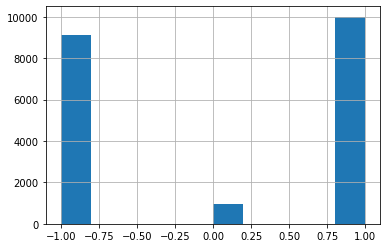

In [ ]:
df['winner_int'] = df.winner.replace({'white':1, 'black':-1, 'draw':0})
df.winner_int.hist()

The intention behind ELO ratings was that they would serve as features in a simple logistic regression model that predicted the probability of the white player winning $y$, i.e.,
$$
logit(y) = \frac{ ELO_{white} - ELO_{black}}{400}.
$$
In this spirit, let's build a slightly more complicated (but still simple) multi-nomial logistic regression model. It takes in two features: the white player and black player ratings, and predicts a win, loss, or draw.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# create training set
X = df[['white_rating', 'black_rating']]
y = df.winner_int

# fit and evaluate logistic repression model
mdl = LogisticRegressionCV(random_state=1, cv=5)
mdl.fit(X, y)
mdl.score(X, y)

0.6206999700867484

This model is not extremely accurate, but chess matches between two random players are hard to predict anyways! Use the ```predict_proba()``` method of your model to answer the following questions. Recall that this method gives you the probability of the target being in each of the classes. If you want to match the target to the class label, use the ```mdl.classes_``` parameter.



### Exercises

1. What is the probability of white winning if the white player has an ELO of 1500 and the black player an ELO of 1300?

In [ ]:
# write your code here

mdl.predict_proba([[1500, 1300]])[0,2]
# [0.277, 0.059, 0.66]
# mdl.classes_

0.6534940601778014

2. What is the probability of there being a draw if the white player and black player both have an ELO of 1000? What if they both have an ELO of 2000?

In [ ]:
# write your code here

mdl.predict_proba([[1000, 1000]])[0,1]
mdl.predict_proba([[2000, 2000]])[0,1]

0.03109027284203009

# A simple round robin league

The predicted probabilities of the model will serve as the prior distributions of all matches in our Monte Carlo simulation. In the code below, we will run a Monte Carlo simulation of a two-round robin league between 16 randomly selected players. We have provided code blocks to implement this simulation.

In [ ]:
def sample_winner(mdl, x):

    # generate the winning probabilities based on prediction model mdl
    win_prob = mdl.predict_proba([x])[0]

    #randomly choose between 'black', 'draw' or 'white' based on the probabilities win_prob 
    winner = np.random.choice(a=['black', 'draw', 'white'], p=win_prob) 
    
    return winner

The code below defines a function ```two_round_robins```, that takes in a dataframe containing the players in the tournament and the model for predicting wins. It loops through all pairs of different players:

1. Randomly shuffle them to decide who is white and black
2. Run ```sample_winner()``` to determine the winner
3. Update the ```tourney_scores``` dataframe with 1 point for the winner (or 0.5 if draw)

After simulating the tournament, the function returns the id of the tournament winner. That is, the player with the highest number of points.

In [ ]:
def two_round_robin(tourney_ratings, mdl):

    # generating tourney_scores variable vector to capture scores of tournament
    tourney_scores = pd.DataFrame(index=tourney_ratings.index, columns=['wins'])
    tourney_scores.wins = 0

    # every player plays every other player twice
    all_players = tourney_scores.index
    for player1 in all_players:
        for player2 in all_players:
            if player2 == player1:
                continue

            # randomly assign who will be white and black
            if np.random.rand() > 0.5:     #reference for exercise 3
                p1, p2 = player1, player2
            else:
                p1, p2 = player2, player1

            # sample the winner and update the score
            x = [ tourney_ratings.loc[p1].rating, tourney_ratings.loc[p2].rating ]
            winner = sample_winner(mdl, x)
            
            # if 'white' is winner, then p1 wins, and we update the score
            if winner == 'white':
                tourney_scores.loc[p1].wins += 1
            # if 'black' is winner, then p2 wins, and we update the score
            elif winner == 'black':
                tourney_scores.loc[p2].wins += 1
            # otherwise it is a tie
            else:
                tourney_scores.loc[p1].wins += 0.5
                tourney_scores.loc[p2].wins += 0.5

    return tourney_scores.wins.idxmax()

The following code generates a random selection of 16 players from the list of players. It then creates a dataframe containing the subset of players in the tournament, along with their ratings.


In [ ]:
np.random.seed(0)
players_in_tourney = np.random.choice(a=players.index, size=16, replace=False)

tourney_ratings = players.loc[players_in_tourney]
# players_in_tourney
# tourney_ratings

## Exercises

1. What is the purpose of the `np.random.seed()` function? Without this function, what would happen everytime you were to re-run the code above? 

___

__Answer:__ The random seed function fixes the sample of players. Without this function,`players_in_tourney` will consist of different players each time.


___

2. Plot a histogram of ratings for the players in your tournament. What do the x-axis and y-axis represent?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2de5a71a20>]],
      dtype=object)

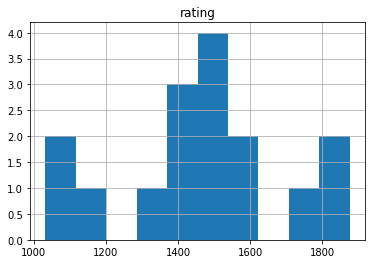

In [ ]:
# Write your code here 

tourney_ratings.hist()
#The x-axis tells you the ELO score, 
#whereas the y-axis tells you the number of players within this bin. 

3. If we changed the `if` statement in the white-black player assignment code above (labeled with "reference for exercise 3") to the `if` statement shown below, would the function remain the same? Why or why not? 

```
if np.random.rand() <= 0.25 or np.random.rand() > 0.75:
```




___

__Answer__: It should stay the same, since `np.random.rand()`, which produces a number between 0 and 1 with uniform distribution, still has 50% chance of producing something satisfying this if statement.

___

4. Why do we even need the if statement discussed in the question above? What if we were to remove that (shown below) block of code entirely? Would this still be fair to the players?

```
if np.random.rand() > 0.5:     
  p1, p2 = player1, player2
else:
  p1, p2 = player2, player1
```


                

___

__Answer:__ We need it to randomly assign players to white or black. This is because white, the first mover, generally has an advantage, as shown in the EDA. 


___

5. Run the ```two_round_robin()``` function to sample a tournament.

In [ ]:
np.random.seed(0)
# Write your code here

two_round_robin(tourney_ratings, mdl)

'firasabdullah'

Each time you run the function above, it will simulate a tournament and will output a winner. Running the code above many times should give you many different potential winners. What we care about is the probabilities that players have of winning the tournament.

___ 

6. We use the `np.random.choice()` function a lot. What are the possible inputs of this function, and what can they do they do? 

7. Given a list `['heads', 'tails']`, can you use the `np.random.choice()` function to simulate a single coin toss? What about a coin toss where heads has 60% chance of appearing? What about simulating 10 coin tosses? You should be able to answer each of these questions by only modifying the parameters of this function.



In [ ]:
np.random.seed(0)
# write your code here

np.random.choice(a = ['heads', 'tails'], p = [0.6, 0.4], size = 10)

array(['heads', 'tails', 'tails', 'heads', 'heads', 'tails', 'heads',
       'tails', 'tails', 'heads'], dtype='<U5')


___

## Running a number of trials

We've provided a function that takes as input the number of trials and a generic tournament simulator function. After every trial, it records the winner of the tournament and updates its estimates of every players win probability.

In [ ]:
def run_monte_carlo(n_trials, ratings, sim, sim_args):
    for i in range(n_trials):
        # print simulation progress
        if i % 20 == 0:
            print('Trial {} of {}...'.format(i, n_trials))

        # pick a winning player
        winner = sim(*sim_args)

        # update the winning probablity of this player 
        ratings.loc[winner, 'winprob'] += 1 / n_trials
    return ratings

# setting up simulation 
n_trials = 100
ratings = tourney_ratings.copy()
ratings['winprob'] = 0.0
sim_args = (tourney_ratings_sample, mdl)

# running simulation
np.random.seed(0)
ratings = run_monte_carlo(n_trials, ratings, two_round_robin, sim_args)
ratings = ratings.sort_values(by=['winprob', 'rating'], ascending=False)

Trial 0 of 100...
Trial 20 of 100...
Trial 40 of 100...
Trial 60 of 100...
Trial 80 of 100...


### Exercises

Answer the following questions.

1. What is one potential downside of trying to run too many trials?


___
__Answer:__ It is computationally expensive.


___


2. What is an upside of running more trials?

___
__Answer:__ You obtain more precise estimates of winning probabilities.


___


3. Plot a bar chart of win probability for your players. What is the ELO of the player most likely to win?

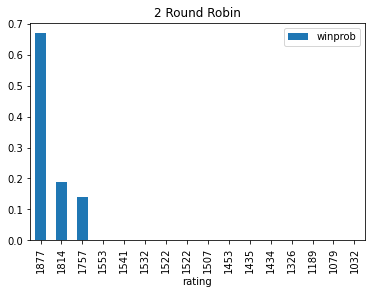

In [ ]:
# Write your code here

ratings.plot(x='rating', y='winprob', kind='bar', title='2 Round Robin')


___

## Tournament design

In this lab, let us define a *fair tournament* as a tournament where the person with the highest ELO score has at least a 75% chance of winning. By this definition, a two-round robin is not fair. Let's see if increasing the number of rounds can make the tournament more fair. In the space below, we have provided a simulator for an $n$-round robin that takes in a parameter $n$ to determine the number of rounds. 


Trial 0 of 100...
Trial 20 of 100...
Trial 40 of 100...
Trial 60 of 100...
Trial 80 of 100...


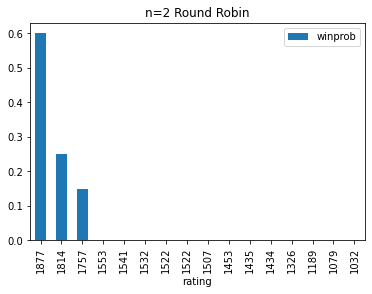

In [ ]:
def n_round_robin(tourney_ratings, mdl, n_matches):
    ''' Every player plays every other place twice. At the start of
    every game, a random coin toss determines who is white.
    '''
    tourney_scores = pd.DataFrame(index=tourney_ratings.index, columns=['wins'])
    tourney_scores.wins = 0
    all_players = tourney_scores.index
    
    # --- Simulation of an n-round robin ---

    # For every player, draw all other players n_matches times.
    for ix, player1 in enumerate(all_players):
        for match in range(n_matches):
            for iy in range(ix+1,len(all_players)):
                player2 = all_players[iy]
                if player2 == player1:
                    continue

                #Randomly select who is white and who is black.
                if np.random.rand() > 0.5:
                    p1, p2 = player1, player2
                else:
                    p1, p2 = player2, player1

                #Sample the winner
                x = [ tourney_ratings.loc[p1].rating, tourney_ratings.loc[p2].rating ]
                winner = sample_winner(mdl, x)

                #Update the tourney_scores dataframe
                if winner == 'white':
                    tourney_scores.loc[p1].wins += 1
                elif winner == 'black':
                    tourney_scores.loc[p2].wins += 1
                else:
                    tourney_scores.loc[p1].wins += 0.5
                    tourney_scores.loc[p2].wins += 0.5

    return tourney_scores.wins.idxmax()

# setting up simulation
n_trials = 100
ratings = tourney_ratings.copy()
ratings['winprob'] = 0.0
n_matches = 2    #default set to 2
sim_args = (tourney_ratings, mdl, n_matches)

# running simulation 
np.random.seed(0)
ratings = run_monte_carlo(n_trials, ratings, n_round_robin, sim_args)
ratings = ratings.sort_values(by=['winprob', 'rating'], ascending=False)
ratings.plot(x='rating', y='winprob', kind='bar', title='n={} Round Robin'.format(n_matches))

While the majority of the code for an n-round robin is identical to that for the 2-round robin, be sure to understand why there are 3 for loops in this code, and what the function of these for loops are.

### Exercises

Answer the following questions:

1. Supose you were to play a 10-round robin, what is the probability that the player with the highest ELO score wins? Is this a "fair" tournament?



Trial 0 of 100...
Trial 20 of 100...
Trial 40 of 100...
Trial 60 of 100...
Trial 80 of 100...


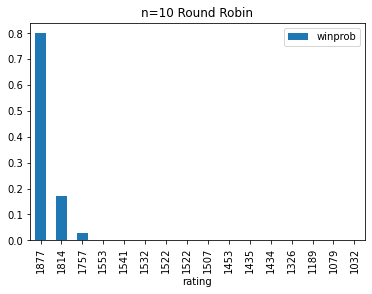

In [ ]:
# Answer your question here

# -----------
n_trials = 100
ratings = tourney_ratings.copy()
ratings['winprob'] = 0.0
n_matches = 10
sim_args = (tourney_ratings, mdl, n_matches)

np.random.seed(0)
ratings = run_monte_carlo(n_trials, ratings, n_round_robin, sim_args)
ratings = ratings.sort_values(by=['winprob', 'rating'], ascending=False)
ratings.plot(x='rating', y='winprob', kind='bar', title='n={} Round Robin'.format(n_matches))
# Yes, this is a fair round robin
# ------------

2. How many games overall does a 10-round robin amount to?


___

__Answer:__ (16 choose 2) * 10 = 1200 games
___

3. Does the code for the 10-round robin take longer to run than a 2-round robin? Why or why not?

___

__Answer:__ It takes longer to run because you are simulating more games.

___

4. Conceptually, if we made $n$ extremely large, i.e., approaching infinity, what would happen to the probability of winning for the player with the highest ELO score? What about the probabilities of players that do not have the highest ELO score?

___

__Answer:__ Assuming there is a unique player with the highest ELO score, this player will win with probability 1 as the number of round robins approaches infinity.

___

The statistical behaviour you are observing is the *Law of Large Numbers*. The player with the highest ELO should win the tournament, as they are the best player. However, there are always random chance events and the best player may not always win. Nonetheless, as you increase the number of games, the randomness of chess is averaged out and the best player will have a high likelihood of winning.





## Simulation over best and worst players

Note that in this simulation, we've sampled randomly from the set of all players. An interesting question to ask is whether this trend holds for the best or the worst players in. In the block below, we've provided some code to sample 16 of the top 500 and the bottom 500 players in the dataset. For both cases, run a Monte Carlo simulation of an $n$-round robin league on the best players. 


In [ ]:
# pick the top 500 players with highest ELO score
top500 = players.nlargest(500,  'rating')

#randomly draw 16 players out of these 500
np.random.seed(0) 
top_players_tourney = np.random.choice(
    a=top500.index, size=16, replace=False)
top_tourney_rating = players.loc[top_players_tourney]
#top_players_tourney

In [ ]:
# pick the bottom 500 players with lowest ELO score
bottom500 = players.nsmallest(500,  'rating')
np.random.seed(0)

#randomly draw 16 players out of these 500
bottom_players_tourney = np.random.choice(
    a=bottom500.index, size=16, replace=False)
bottom_tourney_rating = players.loc[bottom_players_tourney]
#bottom_players_tourney

### Exercises

1. Simulate a 5-round robin for the best players using 100 trials. What is the probability that the best player in the `top_players_tourney` group wins? Is this a fair tournament?




Trial 0 of 100...
Trial 20 of 100...
Trial 40 of 100...
Trial 60 of 100...
Trial 80 of 100...


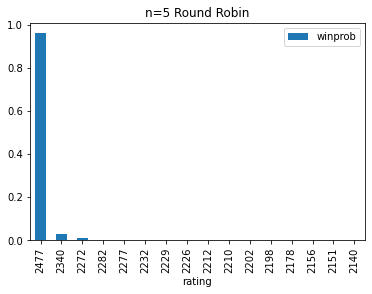

In [ ]:
# Write your code here

# -----------
n_trials = 100
ratings = top_tourney_rating.copy()
ratings['winprob'] = 0.0
sim_args = (top_tourney_rating, mdl, 5)

np.random.seed(0)
ratings = run_monte_carlo(n_trials, ratings, n_round_robin, sim_args)
ratings = ratings.sort_values(by=['winprob', 'rating'], ascending=False)
ratings.plot(x='rating', y='winprob', kind='bar', title='n=5 Round Robin')
# -----------

2. Do the same simulation but for the worst players. What is the probability that the best player in the `bottom_players_tourney` group wins? Is this a fair tournament?

Trial 0 of 100...
Trial 20 of 100...
Trial 40 of 100...
Trial 60 of 100...
Trial 80 of 100...


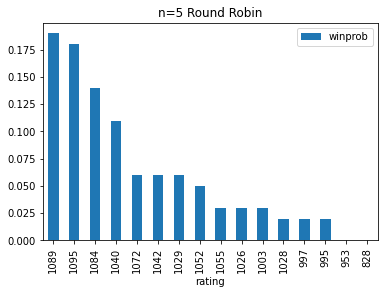

In [ ]:
# Write your code here

# -----------
n_trials = 100
ratings = bottom_tourney_rating.copy()
ratings['winprob'] = 0.0
sim_args = (bottom_tourney_rating, mdl, 5)

np.random.seed(0)
ratings = run_monte_carlo(n_trials, ratings, n_round_robin, sim_args)
ratings = ratings.sort_values(by=['winprob', 'rating'], ascending=False)
ratings.plot(x='rating', y='winprob', kind='bar', title='n=5 Round Robin')
# ------------

3. Why do you think the probabilities that the best player wins is different when you sample from the best or the worst players? HINT: Plot a histogram of the ratings of the players in your tournament, when you are playing with the best and the worst players.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2de564cb38>]],
      dtype=object)

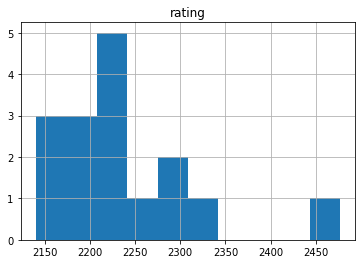

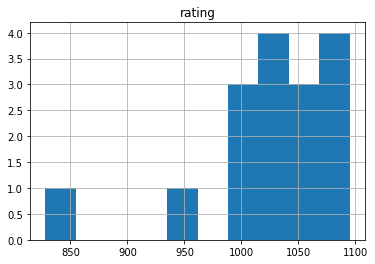

In [ ]:
# Write your code here

top_tourney_rating.hist()
bottom_tourney_rating.hist()

___

__Answers:__ In top list, there is a person that clearly has a ELO score much higher than all other players. On the other hand, in the bottom list, there are a lot of players who all have roughly the same "high" ELO scores. 

___

# Single-elimination tournaments

In order for a round robin league tournament to be fair, you need to play a large number of games. An alternative to leagues is a single elimination tournament. Here, at the start of the tournament every player is put in a random order (which is also called a random seed - not to be confused with the `np.random.seed()` function). Every round, all of the players are paired up with the player next to them in the seeding. The winners of each match proceed to the next round. If there are draws, the players keep playing tiebreakers until there is a winner.

In [ ]:
def single_elimination(tourney_ratings, mdl):
    ''' At the start of the tournament, players are randomly permuted into a seeding.
    Until there is only one player left, we proceed with tournament rounds. In each
    round, each player is paired up with the player next to them. The winner of each
    match proceeds to the next round.
    '''
    # Shuffle the players in a random seed
    players_remaining = np.array(tourney_ratings.index)
    players_remaining = np.random.permutation(players_remaining)
    
    while len(players_remaining) > 1:
        # Assign matchups
        n_matches = int(len(players_remaining) / 2)
        matchups = players_remaining.reshape(n_matches, 2)
        
        winners = []
        for ix in range(n_matches):
            p1, p2 = matchups[ix,0], matchups[ix,1]

            # Keep playing until there is a winner
            drawn_match = True
            while drawn_match is True:
                if np.random.rand() > 0.5:
                    p1, p2 = p1, p2
                else:
                    p1, p2 = p2, p1

                x = [ tourney_ratings.loc[p1].rating, tourney_ratings.loc[p2].rating ]
                
                # simulate who will win the tournament 
                # if it is not a draw, then set drawn_match = False
                winner = sample_winner(mdl, x)
                if winner == 'white':
                    winners.append(p1)
                    drawn_match = False
                elif winner == 'black':
                    winners.append(p2)
                    drawn_match = False
                else:
                    drawn_match = True
            
        players_remaining = np.array(winners)
    return players_remaining[0]
single_elimination(tourney_ratings, mdl)

'yuredouglas'

In the space below, run a Monte Carlo simulation with 100 trials and plot the win probability.

Trial 0 of 100...
Trial 20 of 100...
Trial 40 of 100...
Trial 60 of 100...
Trial 80 of 100...


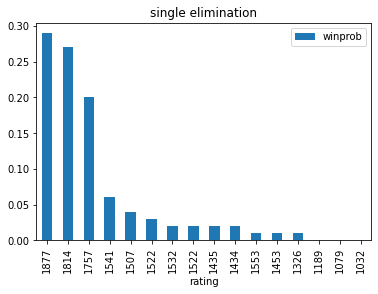

In [ ]:
# setting up simulation
n_trials = 100
ratings = tourney_ratings.copy()
ratings['winprob'] = 0.0
sim_args = (tourney_ratings, mdl)

# running simulation
np.random.seed(0)
ratings = run_monte_carlo(n_trials, ratings, single_elimination, sim_args)
ratings = ratings.sort_values(by=['winprob', 'rating'], ascending=False)
ratings.plot(x='rating', y='winprob', kind='bar', title='single elimination')


## Exercises

1. How does the computational time compare to the round robin tournaments?



___

__Answer:__It is much faster, because there are fewer games to simulate.


___

2. How many games are there in the single-elimination tournament? How does this compare to the 2-round robin?

___

__Answer:__ In a single elimination with 16 players, there are 8 + 4 + 2 + 1 = 15 games. This is far fewer than the (16 choose 2) * 2 = 240 games from 2-round robin.


___

In the Monte Carlo simulation above, change the random.seed to be 2, i.e., `np.random.seed(2)`, and look at the new histogram. You should see something unexpected. What is an explanation for this?


___

__Answer:__ The player with the 1814 ELO score actually wins more games in the 100 trials than the player with the 1877 ELO score. In single elimination tournaments, there is a lot of chance for high variability and upsets.


___

## n-elimination tournament

Because there are far fewer games in an elimination tournament, it is more "fun", in that there are fewer games and a higher chance for upsets. Still, a single elimination tournament isn't particularly fair. Just as we scaled the 2-round robin to an $n$-round robin, let's scale the single elimination to an $n$-elimination tournament. In this tournament style, every matchup is decided by $n$ games. Points in the games are awarded in the standard style (e.g., wins are equal to 1 point, and draws are equal to 0.5 points). Draws are settled by repeating the matchup. Thus, in order to proceed to the next round, you have to win more of the $n$ games than your oponent.

In [ ]:
def n_elimination(tourney_ratings, mdl, n_games):
    ''' At the start of the tournament, players are randomly permuted into a seeding.
    Until there is only one player left, we proceed with tournament rounds. In each
    round, each player is paired up with the player next to them. The winner of each
    match proceeds to the next round. Rounds are determined by n games
    '''
    # Shuffle the players in a random seed
    players_remaining = np.array(tourney_ratings.index)
    players_remaining = np.random.permutation(players_remaining)
    
    while len(players_remaining) > 1:
        
        # Simulation of an n-elimination tournament. 

        # Assign matchups
        n_matches = int(len(players_remaining) / 2)
        matchups = players_remaining.reshape(n_matches, 2)
        
        winners = []
        for ix in range(n_matches):
            p1, p2 = matchups[ix,0], matchups[ix,1]

            # Keep playing for n games
            score_p1, score_p2, iy = 0, 0, 0
            while iy < n_games:
                #select who is white and who is black
                if np.random.rand() > 0.5:
                    x = [ tourney_ratings.loc[p1].rating, tourney_ratings.loc[p2].rating ]
                    #sample winner
                    winner = sample_winner(mdl, x)
                    
                    if winner == 'white':
                        score_p1 += 1
                    elif winner == 'black':
                        score_p2 += 1
                    else:
                        score_p1 += 0.5
                        score_p2 += 0.5
                else:                    
                    x = [ tourney_ratings.loc[p2].rating, tourney_ratings.loc[p1].rating ]
                    # sample winner
                    winner = sample_winner(mdl, x)
                    
                    # update points based on winner
                    if winner == 'white':
                        score_p2 += 1
                    elif winner == 'black':
                        score_p1 += 1
                    else:
                        score_p2 += 0.5
                        score_p1 += 0.5

                # keep playing until there is a winner
                if (iy == n_games - 1) and score_p2 == score_p1:
                  pass
                else:
                  iy += 1

            # decide who winner is after n_games
            if score_p1 > score_p2:
                winners.append(p1)
            else:
                winners.append(p2)
                
        players_remaining = np.array(winners)

    return players_remaining[0]


### Exercises

1. Run the n-elimination simulator where n = 20, simulating 100 trials, with `np.random.seed(2)`. Plot the histogram.

Trial 0 of 100...
Trial 20 of 100...
Trial 40 of 100...
Trial 60 of 100...
Trial 80 of 100...


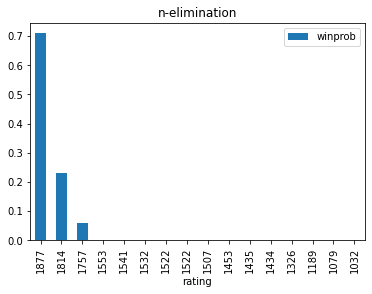

In [ ]:
# Write your code here

# -------------
n_trials = 100
ratings = tourney_ratings.copy()
ratings['winprob'] = 0.0
sim_args = (tourney_ratings, mdl, 20)

np.random.seed(2)
ratings = run_monte_carlo(n_trials, ratings, n_elimination, sim_args)
ratings = ratings.sort_values(by=['winprob', 'rating'], ascending=False)
ratings.plot(x='rating', y='winprob', kind='bar', title='n-elimination')
#ratings
# -------------

2. How does the probability of winning for each player compare to the single-elimination results? In particular, are the results more in line with what you would expect, and are there still unexpected discrepancies between `np.random.seed(0)` and `np.random.seed(2)`?

___

__Answer:__ When n = 20, we find that the player with the 1877 ELO score has a much higher chance of winning than the player with the 1814 ELO score, which was not the case in the single-elimination tournament (with `np.random.seed(2)`). Changing the random.seed number does not change our results.


___

# Conclusion

In general, an elimination tournament is much better for ensuring that the best player wins rather than a league. That is, you should hit a fair tournament in a much smaller number of games. However, there is one key component to elimination tournaments that may make it difficult for the best player to win: the initial seeding. In this lab, we assumed that players are paired randomly in the elimination tournament. If this is not the case, then results can be very different. For example, if all of the best players are paired up early in the seeds, then we may find good players getting knocked out early, potentially with poorer players having higher winning probabilities than some of these good players. 


